In [103]:
### revised APGF implementation

from IPython.core.debugger import set_trace

import numpy as np
from scipy.misc import factorial

import gdual as gd
import forward as fwd #for PGFs only

def tsa(F, k, a = 1, lmbda = None):    
    # tsa_callback := a function of a single variable that is returned by tsa
    # note: tsa_callback shares some parameters with tsa
    #       and imports some precomputed variables from tsa
    def tsa_callback(x):
        nonlocal k, a, lmbda 
        nonlocal coefs, i_set
        
        # R := a function to approximate the remainder term of the TSE
        # note: R shares as parameters k, a
        #       and 'imports' some common computation from tsa_callback
        def R(x):
            nonlocal k, a, lmbda
            nonlocal i_set, series

            # divide the terms by 1 / i!, then sum
            R_series = list(map(lambda term: term[0] / factorial(term[1]), zip(series, i_set)))
            res    = np.sum(R_series)
            # now: res = \sum_{i=0}^k (x-a)^i/i!

            res = lmbda * (np.exp(x - a) - res)
            # now: res = lambda * (e^{x - a} - \sum_{i=0}^k (x-a)^i/i!)

            return(res)
        
        # compute \sum_{i = 0}^k \frac{(s-a)^i}{i!}
        base = x - a
        
        # if s (and therefore base) are dual numbers, then we can't
        # simply broadcast against a vector for the power operation
        series = list(map(lambda i: base ** i, i_set))
        # note at this point, series is either a list of scalars or a list of dual numbers
    
        res = np.sum(coefs * series)
        res = res + R(x)
        
        return(res)

    ##### 
    # precompute anything that doesn't depend on x
    
    # get the series of derivatives F^{(i)}(a) for 0 <= i <= k using an LSGDual
    a_lsgd = gd.LSGDual(a, q = k)
    coefs = F(a_lsgd)
    coefs = coefs.unwrap_coefs(coefs.coefs, as_log = False)
    # note: F_derivs = F^{(i)}(a)/i! (the factorial is already included)

    # if lmbda not specified, use F^{(k)}(a)
    if lmbda is None:
        lmbda = coefs[-1] * factorial(k) # note: need to cancel out (k!)
        
    i_set = np.arange(0, k+1)
    
    return(tsa_callback)

In [ ]:
theta = [4]
k = 100
a = 1
F = lambda s: fwd.poisson_pgf(s, theta)
G = tsa(F, k, a)

q = 20
x = gd.LSGDual(0, q = q)
# print(F(x))
# print(G(x))

# print(factorial(np.arange(0, 5)))

/Users/kwinner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in exp


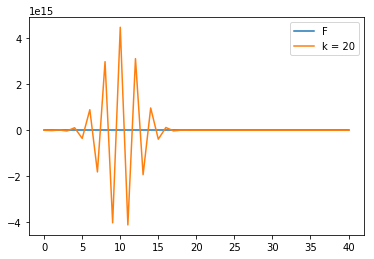

4.47476932334e+15
[  2.27777621e+10  -1.36993858e+13   1.10855807e+13  -3.16555462e+13
   1.09995760e+14  -3.53093826e+14   8.93391792e+14  -1.81018878e+15
   2.97919574e+15  -4.02120606e+15   4.47476932e+15  -4.11127084e+15
   3.11191399e+15  -1.92876094e+15   9.68339441e+14  -3.87086673e+14
   1.19948665e+14  -2.75989276e+13   4.37149929e+12  -4.05711950e+11
   1.22512914e+10   5.83394828e+08   2.65179467e+07   1.15295421e+06
   4.80397586e+04   1.92159034e+03   7.39073209e+01   2.73730818e+00
   9.77610065e-02   3.37106919e-03   1.12368973e-04   3.62480558e-06
   1.13275174e-07   3.43258104e-09   1.00958266e-10   2.88452188e-12
   8.01256079e-14   2.16555697e-15   5.69883413e-17   1.46123952e-18
   3.65309880e-20]
[ 0.00010486  0.00062915  0.00207618  0.00498283  0.00971652  0.01632376
  0.02448564  0.03358031  0.04281489  0.05137787  0.05857078  0.06389539
  0.06709016  0.06812232  0.06714914  0.06446318  0.06043423  0.05545729
  0.04991156  0.04413233  0.03839513  0.03291011  0.02

In [146]:
# visualize d/dx G(x) as a function of k

import matplotlib.pyplot as plt

plt.figure()

theta = [10, 0.4]
a = 1
# F = lambda s: fwd.poisson_pgf(s, theta)
# F = lambda s: fwd.binomial_pgf(s, theta)
F = lambda s: fwd.negbin_pgf(s, theta)

q = 40
x = gd.LSGDual(0, q = q)
fac = factorial(np.arange(q+1))

y_true = F(x)
y_true = y_true.unwrap_coefs(y_true.coefs, as_log = False)
plt.plot(y_true, label='F')

for k in [20]:
    G = tsa(F, k, a)
    y = G(x)
    y = y.unwrap_coefs(y.coefs, as_log = False)
    plt.plot(y, label='k = %d' % k)

# plt.plot(np.abs(y - y_true))

# plt.ylim(0.0, 0.2)
plt.legend()
plt.show()

print(np.max(y))
print(y)
print(y_true)

In [ ]:
# visualize G(s) vs F(s)

import matplotlib.pyplot as plt

theta = [10]
a = 0.01
k = 20
F = lambda s: fwd.poisson_pgf(s, theta)

x_plt = np.linspace(0, 4, 40)
y = list(map(lambda i: np.exp(theta[0] * (i - 1)), x_plt))
# y = y / factorial(y)

plt.plot(x_plt, y, label = 'F')

G = tsa(F, k, a)
y = list(map(G, x_plt))
# y = y / factorial(y)

plt.plot(x_plt, y, label = 'G')

plt.ylim(0.0, 20.0)
plt.legend()

plt.show()

In [111]:
print(y)
print(y_true)
print(1000 * np.exp(-1) - 100 + 10)
print((1000 * np.exp(-1) + 100 - 1000)/2)
print((1000 * np.exp(-1)) / factorial(3))
print((1000 * np.exp(-1)) / factorial(4))

# q_test = gd.LSGDual(1.0, q = k)
# y_test = F(q_test)

# y_test = y_test.unwrap_coefs(y_test.coefs, as_log = False)
# print(y_test)
# y_test = y_test * factorial(np.arange(k+1))
# print(y_test)

[ -9.11205588e+01   2.77879441e+02  -2.66060279e+02   6.13132402e+01
   1.53283100e+01   3.06566201e+00   5.10943668e-01   7.29919526e-02
   9.12399408e-03   1.01377712e-03   1.01377712e-04]
[  4.53999298e-05   4.53999298e-04   2.26999649e-03   7.56665496e-03
   1.89166374e-02   3.78332748e-02   6.30554580e-02   9.00792257e-02
   1.12599032e-01   1.25110036e-01   1.25110036e-01]
277.879441171
-266.060279414
61.3132401952
15.3283100488


/Users/kwinner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in exp
  if __name__ == '__main__':
/Users/kwinner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/Users/kwinner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in exp


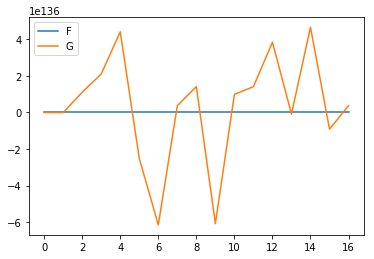

In [4]:
## approximate with the MGF?

import matplotlib.pyplot as plt

theta = [10]
a = 0.001
k = 100
F = lambda s: fwd.poisson_pgf(s, theta)
M = lambda s: F(np.exp(s))
M_hat = tsa(M, k, a)
F_hat = lambda s: M_hat(np.log(s))

F_true = lambda s: np.exp(theta[0] * (s - 1))
M_true = lambda s: np.exp(theta[0] * (np.exp(s) - 1))
# x_plt = np.linspace(0, 4, 40)
# y = list(map(M_true, x_plt))

x = 1
q = 16
x_gdq = gd.LSGDual(x, q)

y_true = F(x_gdq)
y_hat  = F_hat(x_gdq)

plt.figure()

plt.plot(np.arange(q+1), y_true.unwrap_coefs(y_true.coefs, as_log = False), label='F')
plt.plot(np.arange(q+1), y_hat.unwrap_coefs(y_hat.coefs, as_log = False), label='G')

plt.legend()
plt.show()
# print(y)

### Archive

In [ ]:
def tsa_log(F, k, a = 1, lmbda = None):    
    # tsa_callback := a function of a single variable that is returned by tsa
    # note: tsa_callback shares some parameters with tsa
    #       and imports some precomputed variables from tsa
    def tsa_log_callback(x):
        nonlocal k, a, lmbda 
        nonlocal coefs, i_set
        
        # R := a function to approximate the remainder term of the TSE
        # note: R shares as parameters k, a
        #       and 'imports' some common computation from tsa_callback
        def log_R(x):
            nonlocal k, a, lmbda
            nonlocal i_set, series

            # divide the terms by 1 / i!, then sum
            R_series = list(map(lambda term: term[0] / factorial(term[1]), zip(series, i_set)))
            res    = np.sum(R_series)
            # now: res = \sum_{i=0}^k (x-a)^i/i!

            res = lmbda * (np.exp(x - a) - res)
            # now: res = lambda * (e^{x - a} - \sum_{i=0}^k (x-a)^i/i!)

            return(res)
        
        # compute \sum_{i = 0}^k \frac{(s-a)^i}{i!}
        base = x - a
        
        # if s (and therefore base) are dual numbers, then we can't
        # simply broadcast against a vector for the power operation
        series = list(map(lambda i: base ** i, i_set))
        # note at this point, series is either a list of scalars or a list of dual numbers
    
        res = np.sum(coefs * series)
        res = res + R(x)
        
        return(res)

    ##### 
    # precompute anything that doesn't depend on x
    
    # get the series of derivatives F^{(i)}(a) for 0 <= i <= k using an LSGDual
    a_lsgd = gd.LSGDual(a, q = k)
    coefs = F(a_lsgd)
    coefs = coefs.unwrap_coefs(coefs.coefs, as_log = False)
    # note: F_derivs = F^{(i)}(a)/i! (the factorial is already included)

    # if lmbda not specified, use F^{(k)}(a)
    if lmbda is None:
        lmbda = coefs[-1] * factorial(k) # note: need to cancel out (k!)
        
    i_set = np.arange(0, k+1)
    
    return(tsa_callback)

In [ ]:
# non logspace version of apgf

from IPython.core.debugger import set_trace

import numpy as np
from scipy.misc import factorial

import gdual as gd
import forward as fwd #for PGFs only

# F: the PGF to be approximated
# k: the 
def apgf(F, k, a = 1, lmbda = None):
    i = np.arange(k + 1)
    nums = F(gd.GDual(a, q = k, as_log=False))    
    denoms = factorial(i)
    
    coefs = nums.coefs 
    
#     set_trace()
    
    if lmbda is None:
        lmbda = nums.coefs[-1]

    def R(a, k, lmbda):
        def R_callback(s):
            nums_R = list(map(lambda i: (s - a) ** i, i))

            return(lmbda * (np.exp(s - a) - np.sum(nums_R / denoms)))

        return(R_callback)
        
    R_fun = R(a, k, lmbda)
    
    def apgf_callback(s):
        terms = list(map(lambda i: (s - a) ** i, i))
        
#         set_trace()
        
        return(np.sum(coefs * terms) + R_fun(s))
    
    return apgf_callback

# theta = [14, 0.4]
theta = [4]
k = 10
a = 1
G = apgf(lambda s: fwd.poisson_pgf(s, theta), k, a)

print(G(0))
# print(fwd.poisson_pgf(gd.GDual(0, q = 10, as_log=True), theta))

a_gd = gd.LSGDual(1.0000, q = 20, as_log=False)
derivs = G(a_gd)

print(derivs)

derivs_2 = fwd.poisson_pgf(a_gd, theta)

print(derivs_2)

### Testing below

In [ ]:
import numpy as np
from scipy.misc import factorial

import gdual as gd
import forward as fwd

In [ ]:
theta = [14, 0.4]
pgf = lambda s: fwd.binomial_pgf(s, theta)

k = 10
x = 3

a = gd.GDual(x, q=k, as_log=False)

# print(a.coefs)

b = pgf(a)

# print(b.coefs)

In [ ]:
c = np.arange(k+1)
d = np.array(list(map(lambda i: 1./factorial(i), c)))

print(d)

In [ ]:
s = x
lmbda = b.coefs[-1]

print(lmbda)

f = np.array(list(map(lambda i: (s - x) ** i, c)))

print(f)

g = b.coefs * d * f

# print(g)

In [ ]:
print(d * f)

R = lmbda * (np.exp(s - x) - (np.sum(d * f)))

print(np.exp(s - 1))
print(np.sum(d*f))
print(R)

Z = np.sum(g) + R

In [ ]:
print(pgf(s))
print(Z)

In [ ]:
a.coefs

In [ ]:
b.coefs * d * f